In [1]:
!pip install yfinance

https://pypi.org/project/yfinance/ 

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import copy

In [3]:
# def upload_prices_COTdates()


# def make_futureprice_matrix()

In [4]:
# Файл с датировкой отчетов СОТ
dates_url = 'https://raw.githubusercontent.com/ForestTiger-GH/COTRA/main/Даты%20отчетов%20СОТ.txt'
dates = pd.read_csv('https://raw.githubusercontent.com/ForestTiger-GH/COTRA/main/COTR_Dates.txt', parse_dates=True)

In [5]:
dates['Date'] = pd.to_datetime(dates['Date'])
# dates['fDate'] = dates['Date']

In [6]:
# Commodities
Wheat_SRW = yf.Ticker('ZW=F').history(period="max")
Wheat_SRW.index.name = 'Index'
Wheat_SRW['Date'] = Wheat_SRW.index
XXX = Wheat_SRW.append(dates)
Wheat_SRW = XXX.sort_values(by=['Date', 'Close'], ascending=True).ffill().drop_duplicates(subset=['Date']).merge(dates['Date'], how='right')

Soybeans = yf.Ticker('ZS=F').history(period="max")
Soybeans.index.name = 'Index'

In [7]:
# Financial
Canadian_Dollar = yf.Ticker('6C=F').history(period="max")
Canadian_Dollar.index.name = 'Index'
Canadian_Dollar['Date'] = Canadian_Dollar.index
XXX = Canadian_Dollar.append(dates)
Canadian_Dollar = XXX.sort_values(by=['Date', 'Close'], ascending=True).ffill().drop_duplicates(subset=['Date']).merge(dates['Date'], how='right')

British_Pound = yf.Ticker('6B=F').history(period="max")
British_Pound.index.name = 'Index'
British_Pound['Date'] = British_Pound.index

In [8]:
column_week_prefix = "Week_"
column_bilweek_prefix = "Bin_Long_Week_"
column_bisweek_prefix = "Bin_Short_Week_"
column_binweek_prefix = "Bin_Neut_Week_"
number_future_weeks = 5

target_price_count = 0.07
skip_count_less = 5

Wheat_SRW.drop('Dividends', axis=1, inplace=True)
Wheat_SRW.drop('Stock Splits', axis=1, inplace=True)

In [9]:
for i in range(number_future_weeks):
    Wheat_SRW[str(column_week_prefix + '%03d' % (i+1))] = ((Wheat_SRW['Close'].shift(-i-1)) / Wheat_SRW['Close'] - 1)

    Wheat_SRW[str(column_bilweek_prefix + '%03d' % (i+1))] = Wheat_SRW[str(column_week_prefix + '%03d' % (i+1))]
    Wheat_SRW[str(column_bisweek_prefix + '%03d' % (i+1))] = Wheat_SRW[str(column_week_prefix + '%03d' % (i+1))]
    Wheat_SRW[str(column_binweek_prefix + '%03d' % (i+1))] = Wheat_SRW[str(column_week_prefix + '%03d' % (i+1))]

    Wheat_SRW.loc[Wheat_SRW[str(column_bilweek_prefix + '%03d' % (i+1))] >= target_price_count, str(column_bilweek_prefix + '%03d' % (i+1))] = 1
    Wheat_SRW.loc[Wheat_SRW[str(column_bilweek_prefix + '%03d' % (i+1))] < target_price_count, str(column_bilweek_prefix + '%03d' % (i+1))] = 0

    Wheat_SRW.loc[Wheat_SRW[str(column_bisweek_prefix + '%03d' % (i+1))] <= -target_price_count, str(column_bisweek_prefix + '%03d' % (i+1))] = 1
    Wheat_SRW.loc[Wheat_SRW[str(column_bisweek_prefix + '%03d' % (i+1))] > -target_price_count, str(column_bisweek_prefix + '%03d' % (i+1))] = 0

    Wheat_SRW.loc[((Wheat_SRW[str(column_binweek_prefix + '%03d' % (i+1))] > -target_price_count) & (Wheat_SRW[str(column_binweek_prefix + '%03d' % (i+1))] < target_price_count)), str(column_binweek_prefix + '%03d' % (i+1))] = 1
    Wheat_SRW.loc[(Wheat_SRW[str(column_binweek_prefix + '%03d' % (i+1))] <= -target_price_count) & (Wheat_SRW[str(column_binweek_prefix + '%03d' % (i+1))] >= target_price_count), str(column_binweek_prefix + '%03d' % (i+1))] = 0

# Исправить шорт - нули
# Исправить нейтраль - ставит десятичные доли

In [10]:
matrix_long = Wheat_SRW.iloc[:, 7:].sort_index(axis=1).iloc[:, : number_future_weeks]
matrix_neutral = Wheat_SRW.iloc[:, 7:].sort_index(axis=1).iloc[:, number_future_weeks : number_future_weeks*2]
matrix_short = Wheat_SRW.iloc[:, 7:].sort_index(axis=1).iloc[:, number_future_weeks*2 : number_future_weeks*3]
matrix_real = Wheat_SRW.iloc[:, 7:].sort_index(axis=1).iloc[:, number_future_weeks*3 : number_future_weeks*4]

Ошибка в Bin_Neut_week - выводит дробные числа (хотя откуда!?)

Ошибка в Bin_Short_week - всё вчистую обнулено

Ошибка в Week_# (не бинарная, крайняя справа матрица) - отсутствует неделя 001

In [11]:
# matrix_real[0:25]
aaa = Wheat_SRW.iloc[:, 7:].sort_index(axis=1)
aaa[0:15]

,Bin_Long_Week_001,Bin_Long_Week_002,Bin_Long_Week_003,Bin_Long_Week_004,Bin_Long_Week_005,Bin_Neut_Week_001,Bin_Neut_Week_002,Bin_Neut_Week_003,Bin_Neut_Week_004,Bin_Neut_Week_005,Bin_Short_Week_001,Bin_Short_Week_002,Bin_Short_Week_003,Bin_Short_Week_004,Bin_Short_Week_005,Week_002,Week_003,Week_004,Week_005
0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,-0.027792,-0.001573,0.019402,0.003146
1,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.008475,0.029661,0.013242,0.058792
2,0.0,0.0,0.0,1.0,0.0,1.000000,1.000000,1.000000,0.078209,1.000000,0.0,0.0,0.0,0.0,0.0,0.048544,0.031823,0.078209,0.043689
3,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.004727,0.049895,0.016282,-0.017332
4,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.028292,-0.004630,-0.037551,-0.052469
5,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.011500,-0.021955,-0.037114,-0.057501
6,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,-0.078539,-0.098049,-0.135068,0.0,0.0,0.0,0.0,0.0,-0.064032,-0.078539,-0.098049,-0.135068
7,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,-0.106460,1.000000,0.0,0.0,0.0,0.0,0.0,-0.048062,-0.068217,-0.106460,-0.066150
8,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,-0.075895,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,-0.036344,-0.075895,-0.034206,-0.014965
9,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,-0.061346,-0.019001,0.000543,-0.040174


In [12]:
Wheat_SRW['Long'] = matrix_long.sum(axis=1)
Wheat_SRW['Short'] = matrix_short.sum(axis=1)
Wheat_SRW['Neutral'] = matrix_neutral.sum(axis=1)
Wheat_SRW['Net'] = Wheat_SRW['Long'] - Wheat_SRW['Short']

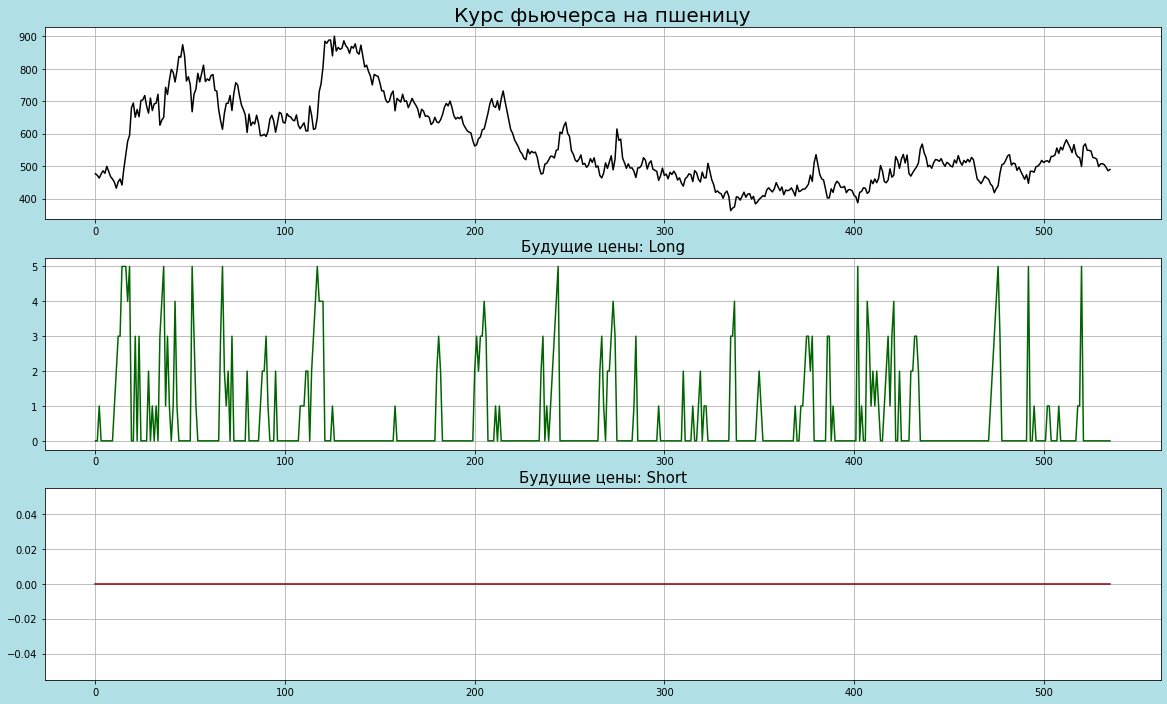

In [13]:
fig = plt.figure()
ax_1 = fig.add_subplot(3, 1, 1)
ax_1.grid()
ax_2 = fig.add_subplot(3, 1, 2)
ax_2.grid()
ax_3 = fig.add_subplot(3, 1, 3)
ax_3.grid()
fig.set(facecolor = 'powderblue')

ax_1.set_title('Курс фьючерса на пшеницу', fontsize = 20)
ax_1.plot(Wheat_SRW['Close'], color='black')
ax_2.set_title('Будущие цены: Long', fontsize = 15)
ax_2.plot(Wheat_SRW['Long'], color='darkgreen')
ax_3.set_title('Будущие цены: Short', fontsize = 15)
ax_3.plot(Wheat_SRW['Short'], color='darkred')

fig.set_figwidth(20)
fig.set_figheight(12)
fig.show()